# Chapter 13: Survival Analysis

In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa
import matplotlib.pyplot as plt
import nsfg
from statsmodels.distributions.empirical_distribution import ECDF
import lifelines
from collections import Counter
import os

%matplotlib inline

## Survival Analysis
**Survival Analysis**: a set of methods for describing & predicting life-times (*how long things last *), or more generally time until an event occurs (**duration**).

Estimate of the probability of surviving `X` years ("X-year survival rate") after diagnosis of a life-threatening disease and related statistics are the result of survival analysis.

### Applications
Traditionally, survival analysis was develop to measure lifespans of individuals (e.g. *How long does this population live for?*).  It's applications extends beyond traditional births and deaths, *but **any duration*** until an event occurs.

*Examples*:
  * human lifetimes (*time to death in biological systems*)
  * "survival" of mechanical & electronic components
  * How long can we expect a user to be on a website/service?
  * Time to recovery for lung cancer treatment
  
### Core Topics
  1. **Survival Function** (*`S`*): probability that event (e.g. death) has not occurred yet at time (`t`).
    * Estimation: **Kaplan-Meier**
  2. **Hazard Function**: probability of the event happening (e.g. "death") in the next instant (`λ`).
    * Estimation: **Nelson-Aalen**
    
https://plot.ly/ipython-notebooks/survival-analysis-r-vs-python/#Survival-Analysis-with-Plotly:-R-vs.-Python

## Survival Curves (*`S`*)
**Survival Curve** (`S(t)`): a function that maps from a duration (`t`) to the probability of surviving longer than `t`. 
  * complement of the CDF of the distribution of durations ("lifetimes")
  
In other words, it's the probability that the **event** (e.g. death) has not occurred yet at time (**`t`**). More equivalently, it's the probability of surviving until at least time (`t`).

`S(t) = Pr( T > t)`
  * **S**: a probability at time `t`
    * `0 ≤ S(t)≤ 1`
  * **Pr**: probability of survival times
    * survival times are non-negative (**T ≥ 0 **)
    * S(0) = 1.0
  * **T**: denotes time of event (e.g. death)
  

#### Survival Function Equation
`S(t) = 1 - CDF(t)`  
  * CDF(t): probability of a lifetime ≤ `t`

In [2]:
def survival_function(cdf_obj, percentile):
    """Function takes the CDF object and percentile and returns the corresponding
    survival curve.
    """
    return 1 - cdf_obj([percentile])[0]

### NSFG Example: Pregnancies
The duration of 11,189 pregnancies is known.

Completed pregnancies have `outcome` values of `1, 3,` & `4`.
`outcome` (11,189):
  * `1` (live birth): 9148
  * `3` (still birth): 120
  * `4` (miscarriage): 1921

#### pandas `query()` method
`pandas.DataFrame.query()` method takes a boolean expression and evaluates it for each row, *selecting the rows that yield True*.

In [3]:
preg = nsfg.ReadFemPreg()
complete = preg.query('outcome in [1,3,4]').prglngth
cdf_preg = ECDF(complete)

The `x` attribute of the ECDF StatsModels method is equivalent to the original `x` input (*lifetimes*).

In [4]:
compare = complete.sort_values() == cdf_preg.x[1:]
compare.value_counts()

True    11189
Name: prglngth, dtype: int64

Compress list to unique values. Original list has multiple duplicate values, which have the same CDF values (*each value is tied to a CDF/percentile*). 

**Note**: This smooths the curve by preventing the plotting of duplicate data points. Data points of the same `x` have the same percentile or CDF value (`y`).

In [5]:
cdf_x = np.unique(cdf_preg.x[1:]).astype(int) # sequence of unique lifetimes
cdf_y = np.array([cdf_preg([x])[0] for x in cdf_x])

In [6]:
# surv_curve = 1 - cdf_preg.y[1:]
surv_curve = 1 - cdf_y

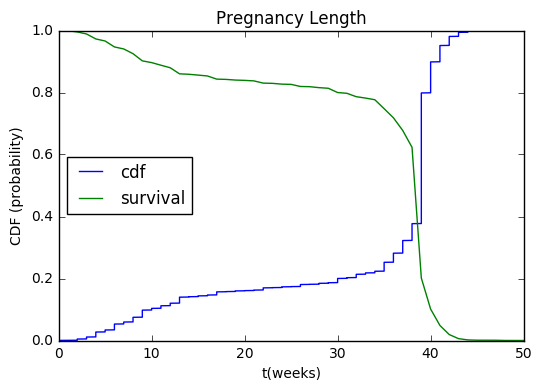

In [7]:
# plt.plot(complete.sort_values(), cdf_preg.y[1:])
plt.plot(cdf_preg.x, cdf_preg.y, label='cdf')
# plt.plot(range(int(cdf_preg.x.max()) + 1), surv_curve, label='survival')
plt.plot(cdf_x, surv_curve, label='survival')
plt.xlabel('t(weeks)')
plt.ylabel('CDF (probability)')
plt.title('Pregnancy Length')
plt.legend(loc='best')
plt.show()

Plot of survival curve (`S(t)`) and CDF (percentiles) of pregnancy length.

The curve is nearly flat between 13 and 26 weeks (2nd trimester), which shows that few pregnancies end in the second trimester.

The curve is steepest around 39 weeks (3rd trimester), which is the most common pregnancy length.

#### Survival Function
Determine the survival curve to its corresponding lifetime (`x`) in *weeks*.

**Lifetime: 13 weeks**

In [8]:
# 1 - cdf([13])[0]
survival_function(cdf_preg, 13)

0.86021985878988294

In [9]:
cdf_preg([13])[0]

0.13978014121011709

The survival curve (fraction) of pregnancies that proceeded past the first trimester (lifecyle: *13 weeks*) is 0.86022.

About 86% of pregnancies reached the 1st trimester and 14% did not.

## Hazard Function **(`λ(t)`)**
**Hazard Function**: a function that maps from time (`t`) to the fraction of people alive until `t` who die at `t`.
  * derived from the **survival curve**
  * important tool for **estimating survival curves**.

It depicts the probability of the event happening (e.g. "death") in the next instant, given that the event has not occurred yet.

### Equation  
**`λ(t) = (S(t) − S(t + 1)) / (S(t))`**

  * Numerator: fraction of lifetimes *that end at `t`*
    * which is also **`PMF(t)`**
    
The function is non-parametric, enabling easy conversion between **survival functions** and **hazard functions**.
    
**Example**: The hazard function maps from a time (`t`) to the fraction of pregnancies that continue until `t` *and then end at `t`*.

In [10]:
def hazard_func(cdf_obj, t):
    
    surv_curve_t = survival_function(cdf_obj, t)
    lam = (surv_curve_t - survival_function(cdf_obj, t+1)) / surv_curve_t
    return lam

In [11]:
hazard_func(cdf_preg, 39)

0.49689440993788825

Of all pregnancies that proceed until **week 39**(`t`), about 50% *end in week 39*.

#### Plot: Hazard Function of NSFG Pregnancy Lengths
The hazard function is erratic after week 42 because it is based on a small number of cases. Aside from this, the shape of the curve is as is expected:
  * The highest is around **39 weeks**
  * values are a little higher in the first trimester than in the second

In [12]:
hazard_curve = []
for elem in cdf_x:
    hazard_curve += [hazard_func(cdf_preg, elem)]

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


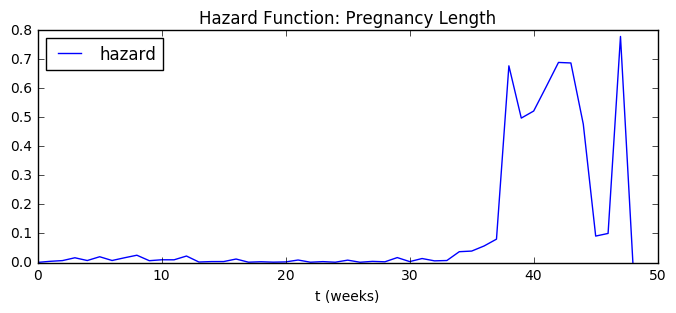

In [13]:
plt.figure(figsize=(8,3))
plt.plot(cdf_x, hazard_curve, label='hazard')
plt.xlabel('t (weeks)')
plt.title('Hazard Function: Pregnancy Length')
plt.legend(loc='best')
plt.show()

# Estimation
## Inferring Survival Curves
In real-world scenarios, the distribution or CDF of lifetimes are not measured directly. Instead, they must be *inferred*.
  * Example: Suppose you're following a group of patients to see how long they survive after a diagnosis. Not all patients are diagnosed on the same day, so at any point in time, some patients may have survived longer than others. If some patients have passed, we know their survival times. For patients still alive, their survival times are unknown, but the lower bound is known.
  
The survival curve cannot always be computed until after all patients have passed. For instance, the evaluation of the effectiveness of a new treatment would require earlier computation with *incomplete information*.  

### Survival Analysis Inference Methods:
  1. Kaplan-Meier
  2. Nelson-Aalen

### NSFG Example - Respondents' "Survival" (Age) Until 1st Marriage
Estimate the hazard function and survival function for age at first marriage. Quantify how long respondents "survive" *until they get married for the first time*. The range of respondents' ages is 14-44 years. Thus, the data provides a snapshot of women at different stages in their lives.

The data provides the age at first marriage for *some* women:
  * **Married women**: dataset includes the date of their 1st marriage and their age at the time.
  * **Unmarried women**: data includes age during time of interview, but incomplete information regarding if and when they got married

**Note**: It's tempting to exclude the women with unknown marriage info and compute the CDF of known data, but this is ***poor practice***.
  * Result would be misleading in 2 ways:
    1. Overrepresentation of *older* women (more likely to be married when interviewed*)
    2. Overrepresentation of *married* women
  * False Conclusion that all women get married, which is incorrect.
  
#### Dataset Features
  * **`cmbirth`**: The respondent's date of birth, known for all respondents.
  * **`cmintvw`**: The date the respondent was interviewed, known for all re-
spondents.
  * **`cmmarrhx`**: The date the respondent was rst married, if applicable and
known.
  * **`evrmarry`**: 1 if the respondent had been married prior to the date of
interview, 0 otherwise.

The first 3 features are encoded in "century-months", so the integer represents the number of months since December 1899.

Read in respondent file

In [14]:
resp = nsfg.ReadFemResp()
resp.shape

(7643, 3087)

Clean up variables
1. Replace invalid values (code 9997, 9998, & 9999) of `cmmarrhx`.
2. Compute each respondent's age when *married* & when *interviewed*.

In [15]:
# Replace invalid values/code with np.nan
resp.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
print resp.shape

# age when married & interviewed
resp['agemarry'] = (resp.cmmarrhx - resp.cmbirth) / 12.0
resp['ageintvw'] = (resp.cmintvw - resp.cmbirth) / 12.0

resp['agemarry'].notnull().sum(), resp['ageintvw'].notnull().sum()

(7643, 3087)


(4089, 7643)

Extract ages:
  * `complete`: age at first marriage for women who have been married
  * `ongoing`: age at interview for women who have not been married

In [17]:
complete = resp[resp.evrmarry==1].agemarry.dropna()
ongoing = resp[resp.evrmarry==0].ageintvw

complete.shape, ongoing.shape

((4089,), (3517,))

4089 of the respondents got married, 3,517 "survived" and remain unmarried (event "*1st marriage*" has not occurred yet).

Create a comprehensive list of age that includes all ages (married and interviewed for those that the event occurred and didn't, respectively).

In [18]:
age = []
for i, row in resp.iterrows():
    if np.isnan(row['agemarry']):
        age += [row['ageintvw']]
    else:
        age += [row['agemarry']]

In [19]:
resp['age'] = age
resp[['age', 'agemarry', 'ageintvw']].head()

,age,agemarry,ageintvw
0,27.666667,NaN,27.666667
1,21.333333,21.333333,42.916667
2,16.833333,16.833333,43.833333
3,16.000000,NaN,16.000000
4,20.166667,NaN,20.166667


Fit KMF with duration (ages) and events_observed (if ever married).

In [20]:
resp[['age', 'evrmarry']].head()

,age,evrmarry
0,27.666667,0
1,21.333333,1
2,16.833333,1
3,16.000000,0
4,20.166667,0


In [21]:
kmf_mrg = lifelines.KaplanMeierFitter().fit(resp.age, event_observed = resp.evrmarry)
kmf_mrg

<lifelines.KaplanMeierFitter: fitted with 7643 observations, 3517 censored>

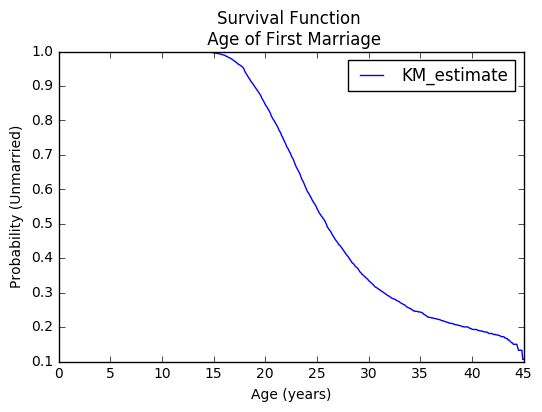

In [22]:
kmf_mrg.survival_function_.plot(title="Survival Function \n Age of First Marriage")
plt.xlabel('Age (years)')
plt.ylabel('Probability (Unmarried)')
plt.show()

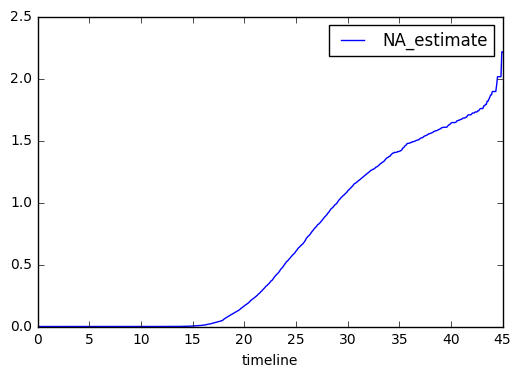

In [23]:
naf_mrg = lifelines.NelsonAalenFitter().fit(resp.age, event_observed = resp.evrmarry)
naf_mrg.cumulative_hazard_.plot()

Approximately 20% survived and were unmarried at age 30.

## Kaplan-Meier Estimation (Survival Function)
**Kaplan-Meier Estimation**: an algorithm for estimating *survival functions/curves*.
  * central algorithm in survival analysis
  
It's a popular estimate for the survival function (**`S(t)`**), which uses *observed data* to estimate without having the *actual survival function* of a population.

#### Censorship
Censoring is a type of missing data problem common in survival analysis. Ideally, both *birth* and *death* rate of a patient is known as it would means the *lifetime* is known.

  * **Right-censoring**: occurs when the death is *unkown*, but it is after some known date.
    * info is *lost* if they're still alive at time (`t`) since time of "death" is unknown
  * **Left-censoring**: occurs when the lifetime is known to be less than a certain duration.
  
### Python Package: Lifelines
https://lifelines.readthedocs.io/en/latest/Quickstart.html  
`lifelines.KaplanMeierFitter().fit(event_times, event_observed=None, label='KM-estimate')

Parameters:
  * **`event_times`**: an array of length `n` of *times* that the death event occurred at
    * an array of the durations
  * **`event_observed`**: an array (of length `n`) -- array of binary/boolean representing whether "death" was observed
    * `True` if the death was observed
    * `False` if the event was lost (**right-censored**)
    * Defaults all `True` if `event_observed == None`
  * **`timeline`**: set the index of the survival curve to this positively increasing array
  * **`label`**: string name of the column of the estimate
  * **`alpha`**: alpha value in the confidence intervals

Attributes (*after fitting*):
  * **`.survival_function_`**
  * **`median_`**
  
Methods (*after fitting*):
  * **`plot()`**
  
#### Duration Conversion (Data Formatting)
**Sublibrary: `lifellines.utils`**
https://lifelines.readthedocs.io/en/latest/Intro%20to%20lifelines.html#estimating-hazard-rates-using-nelson-aalen

`lifelines.utils.datetimes_to_durations(start_date, end_date)`

Parameters:
  * `start_date`: array of start datetimes
  * `end_date`: array of end datetimes
  * `fill_date`

Returns:
  * `T`: durations
  * `C`: events_observed (binary)


Data is not always in the time format of **durations** and instead may be available in the `datetimes64` format. The lifelines package conitains a sublibrary `lifelines.utils` with functions to format raw data.

##### `datetimes_to_durations` Function
The function accepts an array/Pandas object of *start times/dates* and an array/Pandas object of *end times/dates* (or None **if NOT observed**). It outputs the **duration**.

### Example: NSFG Example: Pregnancies
Determine the survival function/curve of completed pregnancies ("death" - end of event). Secondly, illustrate that the KMF approach is analagous to the CDF approach of determining the survival function

Convert outcome into a binary value.

In [24]:
preg2 = preg.copy()
preg2.outcome.replace({4:1, 3:1, 2:0, 5:0, 6:0}, inplace=True)

In [25]:
kmf_preg = lifelines.KaplanMeierFitter().fit(preg2.prglngth, event_observed = preg2.outcome)
kmf_preg

<lifelines.KaplanMeierFitter: fitted with 13593 observations, 2404 censored>

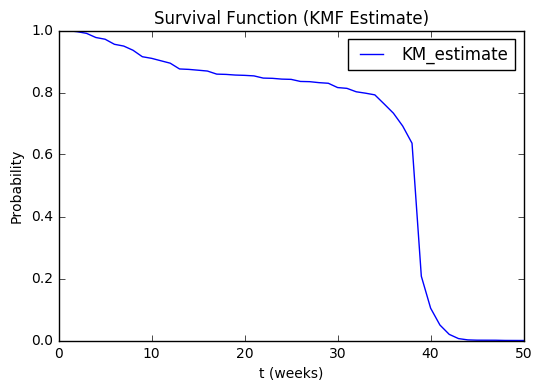

In [26]:
kmf_preg.survival_function_.plot(title='Survival Function (KMF Estimate)')
plt.xlabel('t (weeks)')
plt.ylabel('Probability')
plt.show()

### Example: Tongue Dataset
Perform survival analysis of Type 1 DNA cohort (*aneuploid tumor* DNA profile).

Data Features:
  * **Type**: Tumor DNA profile
    * `1` = Aneuploid Tumor
    * `2` = Diploid Tumor
  * **Time**: time to death
  * **Delta**: death indicator
    * `0`: alive
    * `1`: dead

In [27]:
tongue_path = os.path.join(os.getcwd(), 'tongue.csv')
tongue = pd.read_csv(tongue_path, header = 0, names=['type', 'time', 'delta'])

In [32]:
tongue['delta'].value_counts()

1    53
0    27
Name: delta, dtype: int64

80 total events. 27 of these observations are alive (**right-censored**) and thus their time of "death" is unknown.

In [28]:
tong_kmf = lifelines.KaplanMeierFitter()
tong_kmf.fit(tongue['time'], event_observed = tongue['delta'])

<lifelines.KaplanMeierFitter: fitted with 80 observations, 27 censored>

##### Attribute: Survival Function
Survival Curve of the analysis

In [33]:
tong_survf = tong_kmf.survival_function_
tong_survf.head()

,KM_estimate
timeline,
0.0,1.0000
1.0,0.9750
3.0,0.9375
4.0,0.9125
5.0,0.8875


##### Attribute: Median
The point in time where on average, half of the population has expired (event has occurred).

In [37]:
tong_kmf.median_

73.0

Half of the population has expired since the diagnosis of tumor (aneuploid or diploid) at 73 days.

#### Plot Survival Curve
Plot the curve of the survival function.

S(t=0) is 1.0 as all patients are alive/survived at the start.

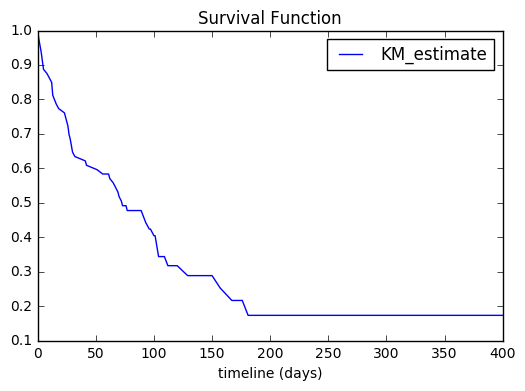

In [35]:
tong_kmf.survival_function_.plot(title='Survival Function')
plt.xlabel('timeline (days)')
plt.show()

#### Quantify Uncertainty (Confidence Intervals)
Plot survival curve with **uncertainty** (confidence intervals) about these point estimates.

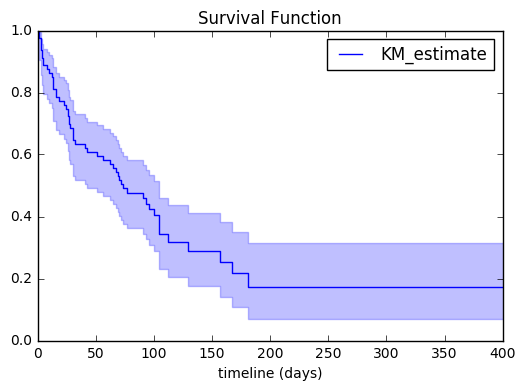

In [36]:
tong_kmf.plot(title='Survival Function')
plt.xlabel('timeline (days)')
plt.show()

#### Interpretation
The `y-axis` is the probability of the event not occuring at time `t` (`x-axis`).

It appears that only 20% of the population survive after about 160 days of diagnosis of a tumor (aneuploid or diploid).

## KMF Estimation: Multiple Types (Cohort Effect)
A challenge of survival analysis that different parts of the estimated survival curve are based on *different groups* (**cohorts**) of respondents. There may be differences between cohorts (**cohort effect**).
  * **cohort**: a group of subjects defned by an event, like date of birth, in a
particular interval of time.

These different groups/cohorts in a single dataset may represent categories such as:
  * treatment groups
  * different species
  * manufacturing techniques

### Example: Tongue
The `type` variable describes the groups/cohorts of patients' DNA profile:
  * `1`: aneuploid cohort
  * `2`: diploid cohort

In [38]:
# Filter for Aneuploid Tumor
aneu = tongue[tongue['type']==1][['time', 'delta']]

aneu_time = aneu['time'] # durations
aneu_delta = aneu['delta'] # observed events (death or not)

# Filter for Diploid Tumor
di = tongue[tongue['type']==2][['time', 'delta']]

di_time = di['time'] # durations
di_delta = di['delta'] # observed events (death or not)

In [40]:
print aneu_delta.value_counts()
print
print di_delta.value_counts()

1    31
0    21
Name: delta, dtype: int64

1    22
0     6
Name: delta, dtype: int64


##### Aneuploid Cohort (Type 1 DNA)
52 total events. 21 of these observations are alive (**right-censored**) and thus their time of "death" is unknown.

##### Diploid Cohort (Type 2 DNA)
28 total events. 6 of these observations are alive (**right-censored**) and thus their time of "death" is unknown.

In [44]:
aneu_kmf = lifelines.KaplanMeierFitter()
aneu_kmf.fit(aneu_time, event_observed=aneu_delta, label=['Type 1 DNA'])

<lifelines.KaplanMeierFitter: fitted with 52 observations, 21 censored>

In [43]:
di_kmf = lifelines.KaplanMeierFitter()
di_kmf.fit(di_time, event_observed=di_delta, label=['Type 2 DNA'])

<lifelines.KaplanMeierFitter: fitted with 28 observations, 6 censored>

##### Attribute: Median
The point in time where on average, half of the population has expired (event has occurred).

In [42]:
print "Aneuploid Median = %d" % aneu_kmf.median_
print "Diploid Median = %d" % di_kmf.median_

Aneuploid Median = 93
Diploid Median = 42


Half of the population has expired since the diagnosis of aneuploid tumor at 93 days.  
On the contary, half of the diploid population has expired at 42 days since the diagnosis of the diploid tumor.

#### Plot Survival Curves
Plot the curve of the survival functions.

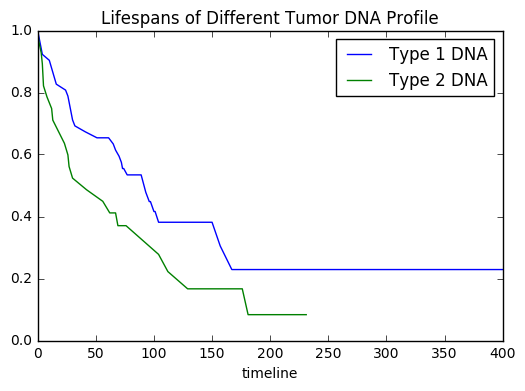

In [49]:
ax = plt.subplot(111)
aneu_kmf.survival_function_.plot(ax=ax)
di_kmf.survival_function_.plot(ax=ax)

plt.title('Lifespans of Different Tumor DNA Profile')
plt.show()

#### Interpretation
The `y-axis` is the probability of the event not occuring at time `t` (`x-axis`).

It appears that only 20% of the Type I DNA population survive after about 160 days of diagnosis of the aneuploid tumor. Whereas, 20% of the Type 2 DNA cohort expires after about 110 days of diagnosis.

Ultimately, Type 2 DNA appears to be potentially more deadly and difficult to treat compared to Type I DNA. The Type 2 DNA cohort has a natural bias towards the event (e.g. death). The survival curve is much steeper, where there's a lower probability of surviving with a specific duration.

### KMF Estimation: Testing for Difference (Statistical Significance)
The differences in survival functions can be tested for between cohorts. More specifically, a statistical test on the different cohorts can be performed to determine if the difference in survival rates are statistically significant.

#### Python Package: Lifelines Statistics
The `lifelines` library contains a statistic sublibrary to compare survival curves.
##### `logrank_test` function
`lifelines.statistics.logrank_test()`  

A common statistical test in survival analysis to compare two event series' generators. If the value returned exceeds some prespecified value, then we rule that the series  have different generators.

#### Hypothesis Testing (Significance Test)
Hypothesis
  * **H<sub>0</sub>**: There survival rates of Type 1 and Type 2 DNA are not statistically significantly different.
  * **H<sub>A</sub>**: There survival rates of Type 1 and Type 2 DNA are statistically significantly different.

In [59]:
from lifelines.statistics import logrank_test
tong_summary = logrank_test(aneu_time, di_time, aneu_delta, di_delta)

tong_summary

<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.09487 |              2.790 |  Cannot Reject Null |       False       
>

#### Conclusion
The p-value is relatively large (p-val > 0.05), providing weak evidence against the H<sub>0</sub>. Hence, the null hypothesis cannot be rejected.

There is ***no*** statistically significant difference between the survival rates of the two cohorts (Type 1 DNA and Type 2 DNA).

## Nelson-Aalen Estimation (Hazard Rates)
**Nelson-Aalen Estimation**: an algorithm for estimating *hazard functions/rates*.

This estimation is an alternative method to determine the survival function, by determining the hazard rate and converting it into the survival curve. Unfortunately, the reverse conversion from the **Kaplan-Meier Estimate** (*survival function*) to the **Nelson-Aalen Estimation** (*hazard rate*) is not feasible.

### General Approach/Idea
1. Use data to estimate the **hazard function**
2. Convert **hazard function** into a **survival curve**

### Python Package: Lifelines
https://lifelines.readthedocs.io/en/latest/Quickstart.html  
`lifelines.NelsonAalenFitter().fit(event_times, event_observed=None, label='KM-estimate')

Parameters:
  * **`event_times`**: an array of length `n` of *times* that the death event occurred at
    * an array of the durations
  * **`event_observed`**: an array (of length `n`) -- array of binary/boolean representing whether "death" was observed
    * `True` if the death was observed
    * `False` if the event was lost (**right-censored**)
    * Defaults all `True` if `event_observed == None`

Attributes (*after fitting*):
  * **`.cumulative_hazard_`**
  * **`median_`**
  
Methods (*after fitting*):
  * **`plot()`**

### Example: Tongue Dataset

In [50]:
aneu_naf = lifelines.NelsonAalenFitter()
aneu_naf.fit(aneu_time, event_observed=aneu_delta)

<lifelines.NelsonAalenFitter: fitted with 52 observations, 21 censored>

##### Attribute: Cumulative Hazard Rate
Hazard rate of the analysis.

In [51]:
aneu_hazf = aneu_naf.cumulative_hazard_
aneu_hazf.head()

,NA_estimate
timeline,
0.0,0.000000
1.0,0.019231
3.0,0.058839
4.0,0.079247
10.0,0.100080


#### Plot Cumulative Hazard Rate
Plot the curve of the hazard function.

λ(t=0) is 1.0 as all patients are alive at time `t=0` and when the event has not occurred yet.

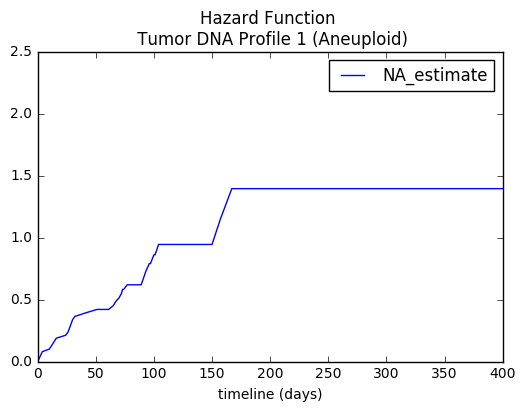

In [52]:
aneu_naf.cumulative_hazard_.plot(title='Hazard Function \n Tumor DNA Profile 1 (Aneuploid)')
plt.xlabel('timeline (days)')
plt.ylim([0, 2.5])
plt.show()

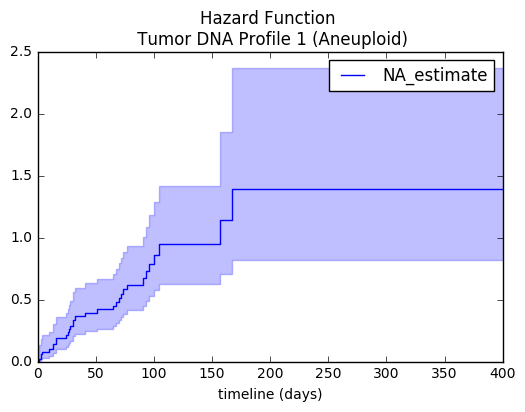

In [53]:
aneu_naf.plot(title='Hazard Function \n Tumor DNA Profile 1 (Aneuploid)')
plt.xlabel('timeline (days)')
plt.show()

#### Interpretation
There is a much higher/steep hazard rate in the first 150 days. The rate of the onset of the event (e.g. death) plateaus after around 190 days.